In [1]:
# default_exp moe

# Merit Order Effect Analysis

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import pickle
from sklearn import linear_model
from sklearn.metrics import r2_score
from collections.abc import Iterable

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import FEAutils as hlp
from ipypb import track

from moepy import lowess, eda
from moepy.surface import PicklableFunction

<br>

### User Inputs

In [3]:
model_fp = '../data/models/DAM_price_p50.pkl'
load_existing_model = False

<br>

### Estimating the Price Surface

We'll start by loading in the data

In [4]:
%%time

df_EI = eda.load_EI_df('../data/electric_insights.csv')

df_EI.head()

Wall time: 5.08 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

We'll do a quick plot of the average price

Text(0, 0.5, 'Day-Ahead Price\nMonthly Average (£/MWh)')

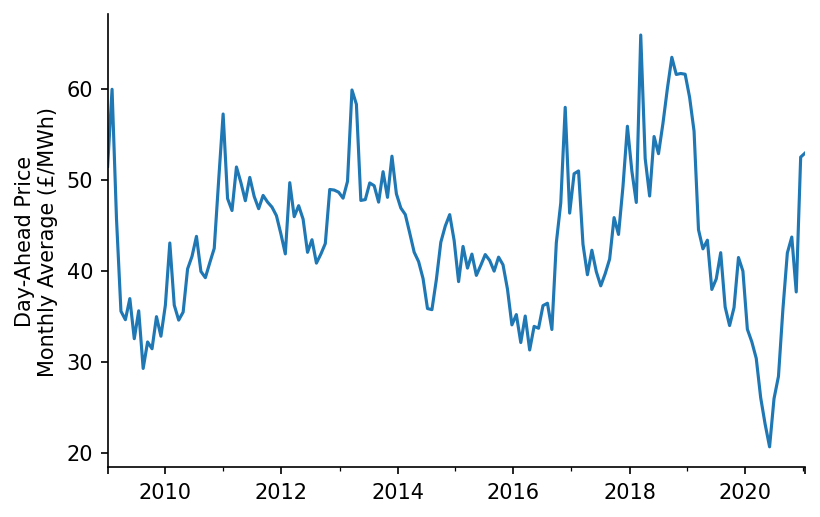

In [5]:
fig, ax = plt.subplots(dpi=150)

df_EI['day_ahead_price'].resample('4W').mean().plot(ax=ax)

hlp.hide_spines(ax)
ax.set_xlabel('')
ax.set_ylabel('Day-Ahead Price\nMonthly Average (£/MWh)')

<br>

We'll also visualise individual half-hour periods for two different date ranges in the dataset

Text(0, 0.5, 'Price (£/MWh)')

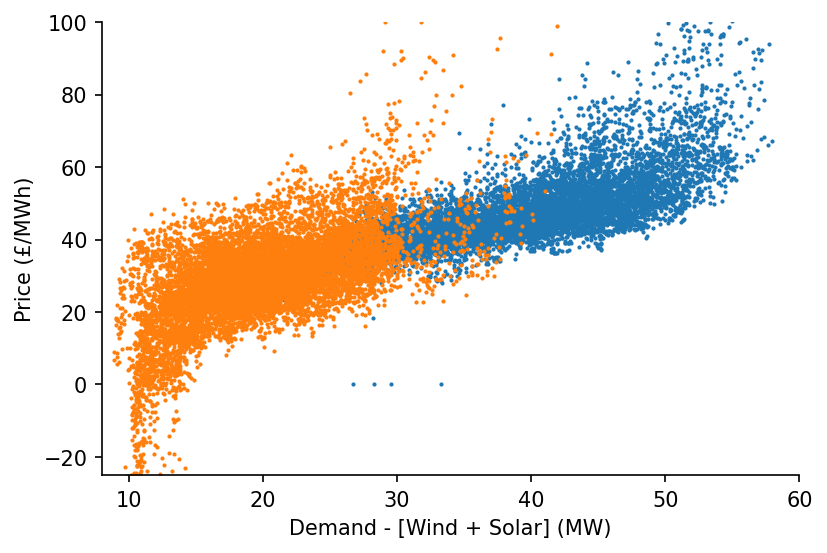

In [6]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

<br>

Next we'll load in (or fit) one of the models trained in the previous notebook

In [7]:
%%time

if load_existing_model == False:
    smooth_dates = pickle.load(open(model_fp, 'rb'))
else:
    reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

    smooth_dates = lowess.SmoothDates()
    smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                     reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26)
    
    pickle.dump(smooth_dates, open(model_fp, 'wb'))

Wall time: 4.02 s


<br>

We're now ready to make our price curve predictions, we'll make one for each day that the model used in training

In [8]:
%%time

x_pred = np.linspace(3, 61, 581)
dt_pred = pd.date_range('2009-01-01', '2020-12-29', freq='1D')

df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)
df_pred.index = np.round(df_pred.index, 1)

df_pred.head()

Wall time: 1.64 s


,2009-01-01,2009-01-02,2009-01-03,2009-01-04,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-10,...,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29
3.0,-17.494810,-17.517832,-17.540635,-17.563220,-17.585587,-17.607740,-17.629683,-17.651422,-17.672962,-17.694305,...,0.176504,0.185334,0.194247,0.203242,0.212319,0.221479,0.230719,0.240041,0.249444,0.258926
3.1,-17.296395,-17.319349,-17.342086,-17.364604,-17.386906,-17.408993,-17.430873,-17.452548,-17.474024,-17.495305,...,0.386785,0.395601,0.404498,0.413478,0.422540,0.431683,0.440907,0.450212,0.459598,0.469064
3.2,-17.098313,-17.121198,-17.143867,-17.166318,-17.188552,-17.210574,-17.232388,-17.253998,-17.275410,-17.296628,...,0.597009,0.605809,0.614692,0.623656,0.632702,0.641829,0.651037,0.660326,0.669695,0.679143
3.3,-16.900560,-16.923375,-16.945975,-16.968357,-16.990523,-17.012478,-17.034225,-17.055769,-17.077116,-17.098268,...,0.807162,0.815947,0.824815,0.833764,0.842794,0.851906,0.861097,0.870370,0.879722,0.889153
3.4,-16.703132,-16.725876,-16.748404,-16.770717,-16.792814,-16.814700,-16.836379,-16.857856,-16.879136,-16.900222,...,1.017233,1.026004,1.034856,1.043790,1.052805,1.061900,1.071076,1.080332,1.089667,1.099082


<br>

### Visualising the Price Surface

We now want to actually visualise the results of our model, in particular the price surface it's fitted. We'll start by plotting all of the price curves overlapping each other.

Text(0.5, 1.0, 'Day-Ahead Market Average Price Curve')

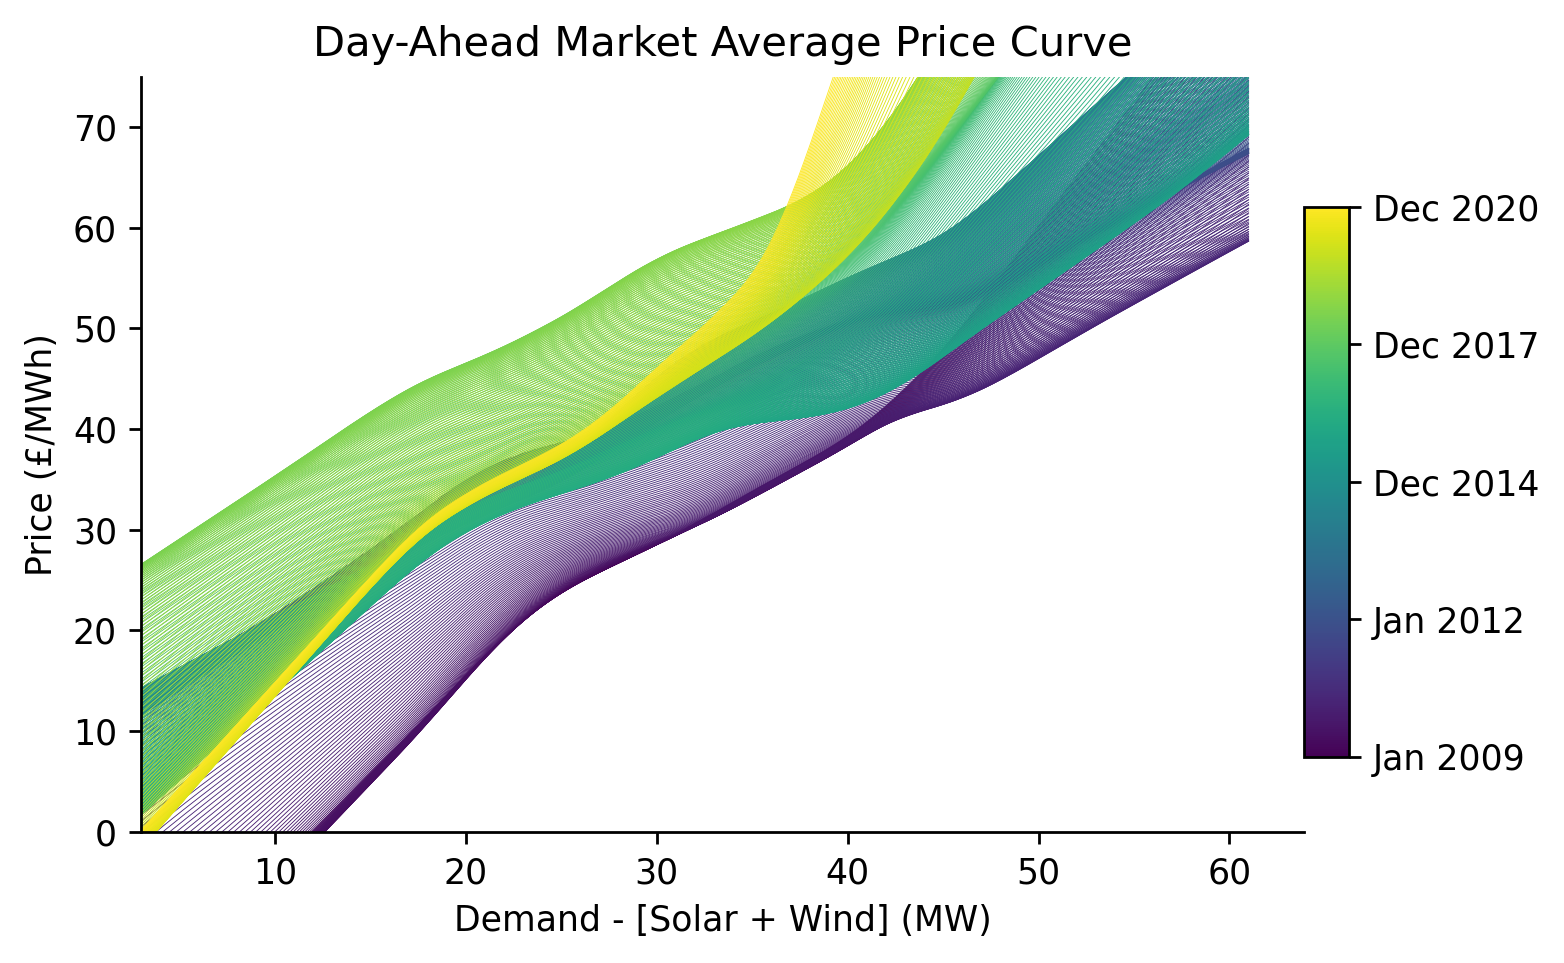

In [9]:
cmap = plt.get_cmap('viridis')
cbar_ticks = [0, 0.25, 0.5, 0.75, 1]

# Plotting
fig, ax = plt.subplots(dpi=250)

lp = df_pred.loc[:, ::7].plot(legend=False, cmap=cmap, linewidth=0.25, ax=ax)

cax = fig.add_axes([0.9, 0.2, 0.03, 0.55])
cbar = mpl.colorbar.ColorbarBase(cax, orientation='vertical', cmap=cmap, ticks=cbar_ticks)
cbar.ax.set_yticklabels([dt_pred[min(int(len(dt_pred)*tick_loc), len(dt_pred)-1)].strftime('%b %Y') for tick_loc in cbar_ticks])

hlp.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (MW)')
ax.set_ylabel('Price (£/MWh)')
ax.set_xlim(df_pred.index[0])
ax.set_ylim(0, 75)
ax.set_title('Day-Ahead Market Average Price Curve')

<br>

Whilst the previous plot might look quite nice it's rather difficult to interpret, an alternative way to visualise how the price curve evolves over time is using a heatmap

<AxesSubplot:>

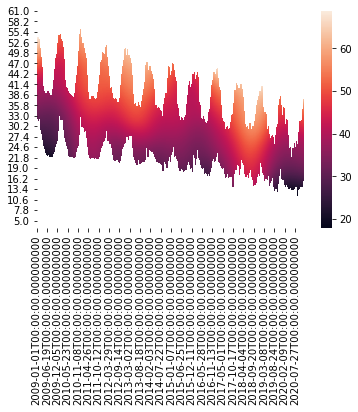

In [10]:
rolling_w = 3

df_dispatchable_lims = (s_dispatchable
                        .resample('1d')
                        .quantile([0.001, 0.999])
                        .unstack()
                        .rolling(rolling_w*7)
                        .mean()
                        .bfill()
                        .ffill()
                        .iloc[:-1, :]
                       )

df_dispatchable_lims.index = pd.to_datetime(df_dispatchable_lims.index.strftime('%Y-%m-%d'))

df_pred_mask = pd.DataFrame(dict(zip(df_pred.columns, [df_pred.index]*df_pred.shape[1])), index=df_pred.index)
df_pred_mask = (df_pred_mask > df_dispatchable_lims.iloc[:, 0].values) & (df_pred_mask < df_dispatchable_lims.iloc[:, 1].values)

df_pred.columns = pd.to_datetime(df_pred.columns)
df_pred_mask.columns = pd.to_datetime(df_pred_mask.columns)

sns.heatmap(df_pred.where(df_pred_mask, np.nan).iloc[::-1])

<br>

The default output for `seaborn` heatmaps never looks great when one of the axis is a datetime, we'll write a custom class and wrapper to handle this

In [57]:
class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs

def set_ticks(ax, tick_locs, tick_labels=None, axis='y'):
    if tick_labels is None:
        tick_labels = tick_locs
    ax_transformer = AxTransformer()
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(tick_locs))
    getattr(ax, f'set_{axis}ticklabels')(tick_labels)
    
    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))
    
    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

Wall time: 3.34 s


C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


<AxesSubplot:ylabel='Demand - [Solar + Wind] (GW)'>

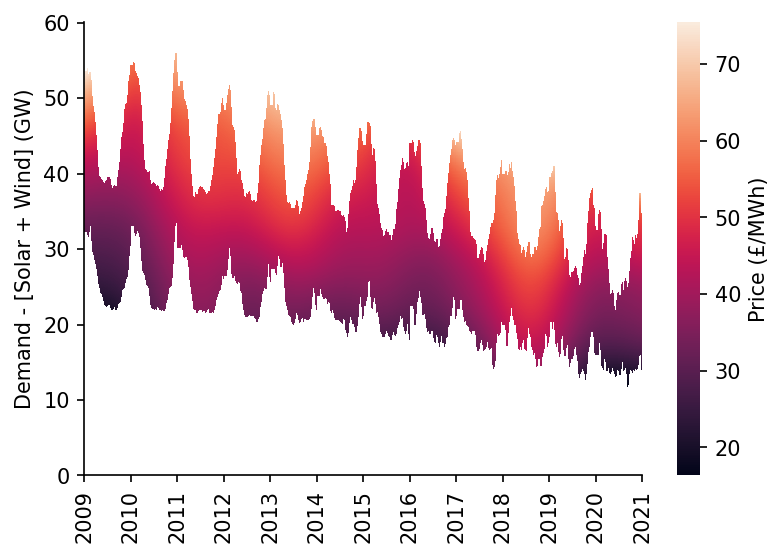

In [58]:
%%time

fig, ax = plt.subplots(dpi=150)

htmp = sns.heatmap(df_pred[10:60].where(df_pred_mask[10:60], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Price (£/MWh)'})

set_ticks(ax, np.arange(0, 70, 10), axis='y')
set_date_ticks(ax, '2009-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
hlp.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

<br>

We also want to visualise specific date ranges, here we'll look towards the end of 2020

Wall time: 120 ms


C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Text(0, 0.5, 'Day-Ahead Price (£/MWh)')

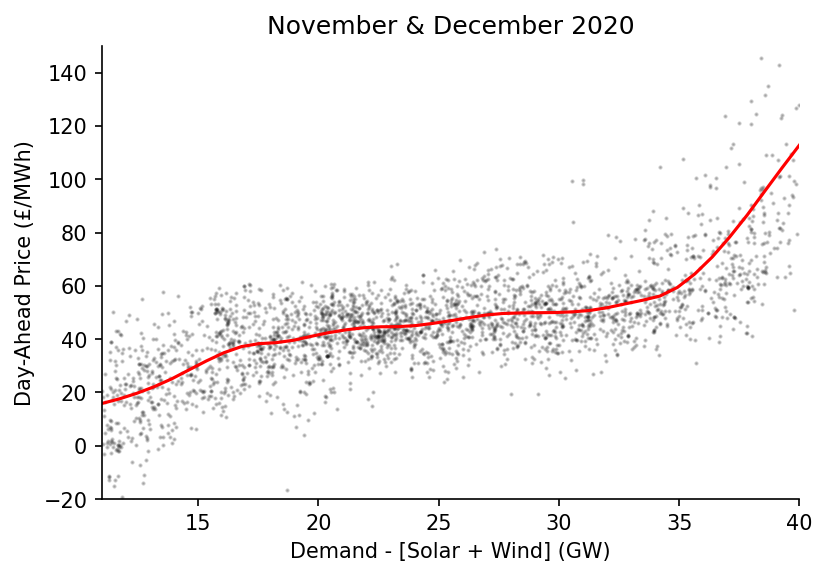

In [13]:
%%time

center_date = '2020-12-01'

dt_min = pd.to_datetime(center_date) - pd.Timedelta(weeks=4)
dt_max = pd.to_datetime(center_date) + pd.Timedelta(weeks=4)

x = s_dispatchable[dt_min:dt_max].values
y = s_price.loc[s_dispatchable.index][dt_min:dt_max].values

x_pred = np.linspace(11, 40, 41)
y_pred = lowess.lowess_fit_and_predict(x, y, frac=0.25, num_fits=25, x_pred=x_pred)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, linewidth=1.5, color='r')
ax.scatter(x, y, color='k', s=1, alpha=0.2)

ax.set_title(f'November & December 2020') # remove in the LaTeX plot and just state in the caption
ax.set_xlim(11, 40)
ax.set_ylim(-20, 150)
hlp.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (GW)')
ax.set_ylabel('Day-Ahead Price (£/MWh)')

<br>

### Evaluating the Price Curve Predictions

In [14]:
#exports
def construct_df_pred(model_fp, x_pred=np.linspace(-2, 61, 631), dt_pred=pd.date_range('2009-01-01', '2020-12-29', freq='1D')):
    smooth_dates = pickle.load(open(model_fp, 'rb'))
    df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)
    df_pred.index = np.round(df_pred.index, 1)
    
    return df_pred

In [15]:
model_fp = '../data/models/DAM_price_average.pkl'

df_pred = construct_df_pred(model_fp)

df_pred.head()

,2009-01-01,2009-01-02,2009-01-03,2009-01-04,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-10,...,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29
-2.0,-28.412220,-28.430584,-28.448767,-28.466768,-28.484586,-28.502217,-28.519660,-28.536910,-28.553964,-28.570820,...,-17.559434,-17.552999,-17.546472,-17.539855,-17.533145,-17.526343,-17.519449,-17.512463,-17.505383,-17.498210
-1.9,-28.217121,-28.235428,-28.253553,-28.271497,-28.289259,-28.306836,-28.324223,-28.341419,-28.358419,-28.375222,...,-17.310899,-17.304459,-17.297928,-17.291305,-17.284592,-17.277786,-17.270888,-17.263898,-17.256815,-17.249639
-1.8,-28.022024,-28.040273,-28.058341,-28.076228,-28.093934,-28.111455,-28.128787,-28.145928,-28.162875,-28.179624,...,-17.062334,-17.055889,-17.049353,-17.042726,-17.036007,-17.029198,-17.022296,-17.015302,-17.008216,-17.001037
-1.7,-27.826927,-27.845118,-27.863129,-27.880959,-27.898609,-27.916074,-27.933352,-27.950439,-27.967332,-27.984028,...,-16.813750,-16.807299,-16.800758,-16.794127,-16.787404,-16.780590,-16.773684,-16.766687,-16.759597,-16.752415
-1.6,-27.631830,-27.649963,-27.667916,-27.685690,-27.703284,-27.720693,-27.737916,-27.754949,-27.771788,-27.788431,...,-16.565158,-16.558702,-16.552156,-16.545520,-16.538792,-16.531974,-16.525065,-16.518063,-16.510970,-16.503785


<br>

Now we've created our prediction dataframe we can calculate a time-series for our price prediction

N.b. to speed things up every 100th half-hour has been sampled rather than using the full dataset

In [16]:
#exports
def construct_pred_ts(s, df_pred):
    s_pred_ts = pd.Series(index=s.index, dtype='float64')

    for dt_idx, val in track(s.iteritems(), total=s.size):
        s_pred_ts.loc[dt_idx] = df_pred.loc[round(val, 1), dt_idx.strftime('%Y-%m-%d')]
        
    return s_pred_ts

In [17]:
s_dispatchable = (df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)).dropna().loc[:df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]

s_pred_ts = construct_pred_ts(s_dispatchable.iloc[::100].iloc[:-1], df_pred)

s_pred_ts.head()

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 2094/2094 [00:04<00:00, 0.00s/it]

local_datetime
2009-01-01 00:00:00+00:00    39.026220
2009-01-03 02:00:00+00:00    34.314689
2009-01-05 04:00:00+00:00    32.502689
2009-01-07 06:00:00+00:00    42.705269
2009-01-09 08:00:00+00:00    64.025113
dtype: float64

<br>

We'll quickly inspect the error distribution

6.859452133034271


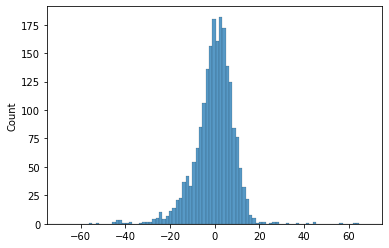

In [18]:
s_price = df_EI['day_ahead_price']

s_err = s_pred_ts - s_price.loc[s_pred_ts.index]
print(s_err.abs().mean())

sns.histplot(s_err)
_ = plt.xlim(-75, 75)

<br>

Now we'll calculate some error metrics, including the option to remove extreme error outliers

In [19]:
#exports
def calc_error_metrics(s_err, max_err_quantile=1):
    if s_err.isnull().sum() > 0:
        s_err = s_err.dropna()
        
    max_err_cutoff = s_err.abs().quantile(max_err_quantile)
    s_err = s_err[s_err.abs()<=max_err_cutoff]
    
    metrics = {
        'median_abs_err': s_err.abs().median(),
        'mean_abs_err': s_err.abs().mean(),
        'root_mean_square_error': np.sqrt((s_err**2).mean())
    }
    
    return metrics

In [20]:
metrics = calc_error_metrics(s_err)

metrics

{'median_abs_err': 4.841062474134425,
 'mean_abs_err': 6.859452133034271,
 'root_mean_square_error': 12.300841073721696}

<br>

We'll now create a wrapper for the last few steps and repeat the analysis for four variants of the model

In [21]:
#exports
def get_model_pred_ts(s, model_fp, s_demand=None):
    df_pred = construct_df_pred(model_fp)
    s_cleaned = s.dropna().loc[df_pred.columns.min():df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]
    s_pred_ts = construct_pred_ts(s_cleaned, df_pred)
    
    if s_demand is None:
        return s_pred_ts
    else:
        s_cleaned = s_demand.dropna().loc[df_pred.columns.min():df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]
        s_pred_ts_demand = construct_pred_ts(s_cleaned, df_pred)
        return s_pred_ts, s_pred_ts_demand

In [22]:
s_demand = df_EI['demand']
s_price = df_EI['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

model_runs = {
    'demand_p50': {
        'model_fp': '../data/models/DAM_price_demand_p50.pkl',
        's': s_demand
    },
    'demand_avg': {
        'model_fp': '../data/models/DAM_price_demand_average.pkl',
        's': s_demand
    },
    'dispatch_p50': {
        'model_fp': '../data/models/DAM_price_p50.pkl',
        's': s_dispatchable
    },
    'dispatch_avg': {
        'model_fp': '../data/models/DAM_price_average.pkl',
        's': s_dispatchable
    },
}

model_outputs = dict()

for model_name, model_kwargs in track(model_runs.items()):
    s_pred_ts = get_model_pred_ts(**model_kwargs)
    s_err = s_pred_ts - s_price.loc[s_pred_ts.index]
    metrics = calc_error_metrics(s_err)
    
    model_outputs[model_name] = {
        's_pred_ts': s_pred_ts,
        's_err': s_err,
        'metrics': metrics
    }

 [############################################################] 0/4 [0<0, 0.00s/it]

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [██████████████████##########################################] 65453/209688 [01:30<00:00, 0.00s/it]

KeyboardInterrupt: 

<br>

Overall, the dispatch model fitted to the median price appears to be the most accurate

In [ ]:
df_metrics = pd.DataFrame({
    name: outputs['metrics'] 
    for name, outputs 
    in model_outputs.items()
})

df_metrics

<br>

We'll quantify the difference against the standard LOWESS approach

In [ ]:
old_err = df_metrics.loc['mean_abs_err', 'dispatch_avg']
new_err = df_metrics.loc['mean_abs_err', 'dispatch_p50']

print(f'{-100*(new_err - old_err)/old_err:.2f}% mean absolute error reduction using the p50 model rather than the average model')

<br>

And also look at the improvement in accuracy when regressing against dispatchable generation instead of total generation

In [ ]:
old_err = df_metrics.loc['mean_abs_err', 'demand_p50']
new_err = df_metrics.loc['mean_abs_err', 'dispatch_p50']

print(f'{-100*(new_err - old_err)/old_err:.2f}% mean absolute error reduction using the dispatchable demand model rather than just demand')

<br>

### Quantifying & Visualising the Merit Order Effect

To begin we'll load up our dispatchable supply model and make an inference for each half-hour in the dataset, based on the results in the previous section we'll use the p50 model.

In [23]:
%%time

s_pred_ts_dispatch, s_pred_ts_demand = get_model_pred_ts(s_dispatchable, model_fp, s_demand=s_demand)
s_err = s_pred_ts_dispatch - s_price.loc[s_pred_ts_dispatch.index]
metrics = calc_error_metrics(s_err)

s_pred_ts_dispatch

 [████████████████████████████████████████████████████████████] 209485/209485 [03:31<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 209688/209688 [02:52<00:00, 0.00s/it]

Wall time: 6min 28s


local_datetime
2009-01-01 00:00:00+00:00    39.026220
2009-01-01 00:30:00+00:00    39.161947
2009-01-01 01:00:00+00:00    38.487798
2009-01-01 01:30:00+00:00    37.032877
2009-01-01 02:00:00+00:00    36.119202
                               ...    
2020-12-29 21:30:00+00:00    41.780486
2020-12-29 22:00:00+00:00    40.218577
2020-12-29 22:30:00+00:00    38.314045
2020-12-29 23:00:00+00:00    36.914033
2020-12-29 23:30:00+00:00    36.070703
Length: 209485, dtype: float64

<br>

The difference between the price forecast when using the dispatchable generation and total generation is due to the merit order effect

<AxesSubplot:xlabel='local_datetime'>

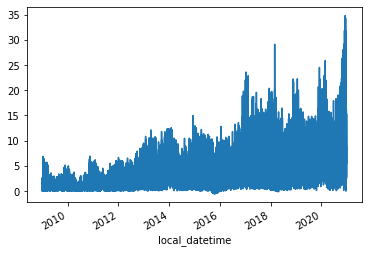

In [27]:
s_MOE = s_pred_ts_demand - s_pred_ts_dispatch
s_MOE = s_MOE.dropna()

s_MOE.plot()

<AxesSubplot:xlabel='local_datetime'>

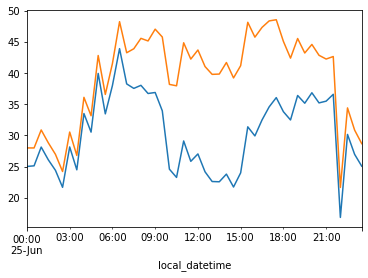

In [36]:
s_price['2020-06-25'].plot()
(s_price['2020-06-25']+s_MOE['2020-06-25']).plot()

In [ ]:
# date = '2017-06-12'
# date = '2017-07-01' - gets the shape really well but misses the magnitude in the morning

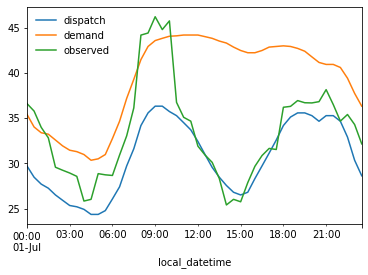

In [128]:
date = '2017-07-01'

s_pred_ts_dispatch[date].plot(label='dispatch')
s_pred_ts_demand[date].plot(label='demand')
s_price[date].plot(label='observed')

plt.legend(frameon=False)

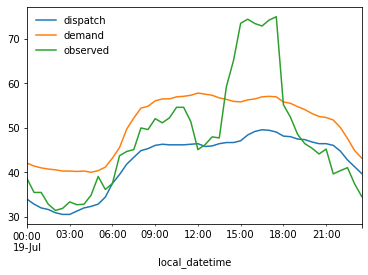

In [31]:
date = '2017-07-19'

s_pred_ts_dispatch[date].plot(label='dispatch')
s_pred_ts_demand[date].plot(label='demand')
s_price[date].plot(label='observed')

plt.legend(frameon=False)

 [████████████████████████████████████████████████████████████] 9/9 [00:32<00:03, 3.56s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 48/48 [00:00<00:00, 0.00s/it]

<AxesSubplot:xlabel='local_datetime'>

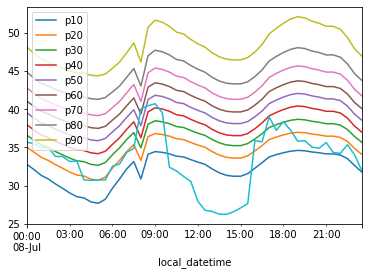

In [136]:
df_pred_ts = pd.DataFrame()

for percentile in track(np.arange(10, 100, 10)):
    df_pred = construct_df_pred(f'../data/models/DAM_price_p{percentile}.pkl')
    df_pred_ts[f'p{percentile}'] = construct_pred_ts(s_dispatchable[date], df_pred)
    
df_pred_ts.plot()
s_price[date].plot(label='observed')

<AxesSubplot:xlabel='local_datetime'>

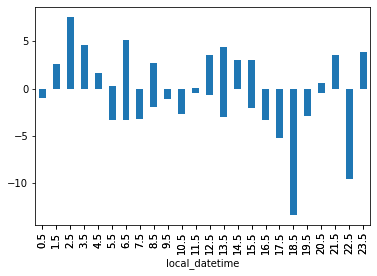

In [144]:
s_err.groupby(s_err.index.hour+s_err.index.minute/60).mean().plot.bar()

<br>

We'll now calculate the half-hourly savings due to the merit order effect. The demand is expressed in terms of GW which we'll convert into MWh to be compatible with the units of the merit order effect.

<AxesSubplot:xlabel='local_datetime'>

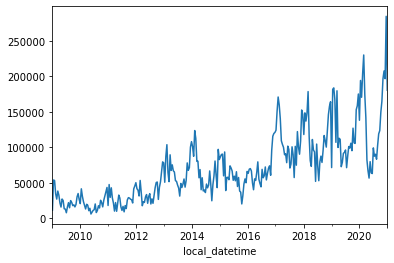

In [137]:
s_saving = s_MOE * df_EI['demand'].loc[s_MOE.index]*1000*0.5

s_saving.resample('2W').mean().plot()

<br>

The distribution of the price savings appears to follow a rough Pareto distribution

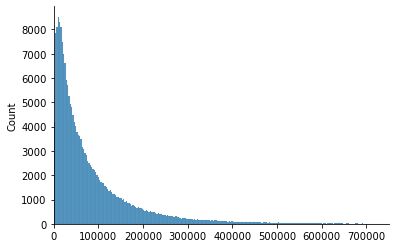

In [446]:
sns.histplot(s_saving)
plt.xlim(0, 750000)
hlp.hide_spines(plt.gca())

<br>

We'll calculate the total savings over the dataset period

In [460]:
total_saving = s_saving.sum()

print(f"The total saving between {s_saving.index.min().strftime('%Y-%m-%d')} and {s_saving.index.max().strftime('%Y-%m-%d')} was £{total_saving:,.0f}")

The total saving between 2009-01-01 and 2020-12-29 was £17,838,623,385


<br>

To add some context we'll calcualate the average half-hourly market volume (note that the DAM volume will be smaller than demand but it acts as a good proxy to cover all markets)

In [434]:
s_mkt_cost = df_EI['day_ahead_price']*df_EI['demand']*1000*0.5

avg_HH_mkt_cost = s_mkt_cost.mean()

784440.8559554707

<br>

We'll also calculate the long-term price reduction due to the merit order effect

In [116]:
s_MOE.mean()/df_EI['day_ahead_price'].mean()

0.11125969014871903

<br>

This only tells part of the story though, lets look at how this value evolves over time

<AxesSubplot:xlabel='local_datetime'>

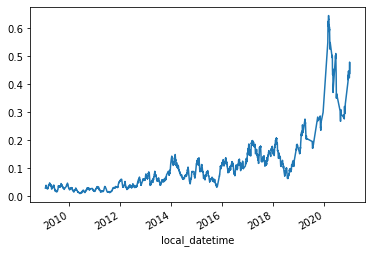

In [377]:
s_MOE_rolling = s_MOE.rolling(48*28).mean().dropna()
s_DAM_rolling = s_MOE.rolling(48*28).mean().dropna()
s_wind_rolling = df_EI.loc[s_MOE.index]['day_ahead_price'].rolling(48*28).mean().dropna()

s_MOE_pct_reduction = s_MOE_rolling/s_DAM_rolling

s_MOE_pct_reduction.plot()

<br>

We're half-way to creating the metrics required for comparing between markets of different sizes, prices and RES penetration. We'll calculate the renewables penetration percentage and then aggregate it on an annual basis alongside the pct price reduction due to the MOE.

Text(0, 0.5, 'Average MOE Price Reduction (%)')

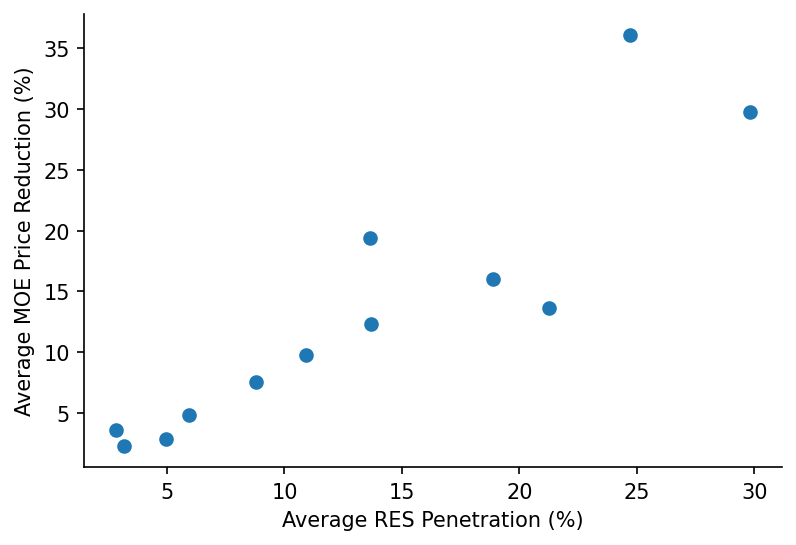

In [421]:
s_MOE_pct_annual_avg = (s_MOE/df_EI.loc[s_MOE.index]['day_ahead_price']).replace(np.inf, np.nan).dropna().pipe(lambda s: s.groupby(s.index.year).mean())
s_RES_pct_annual_avg = (df_EI[['wind', 'solar']].sum(axis=1)/df_EI['demand']).pipe(lambda s: s.groupby(s.index.year).mean())

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(100*s_RES_pct_annual_avg, 100*s_MOE_pct_annual_avg)

hlp.hide_spines(ax)
ax.set_xlabel('Average RES Penetration (%)')
ax.set_ylabel('Average MOE Price Reduction (%)')

<br>

We'll also visualise the how the MOE time-series and trend

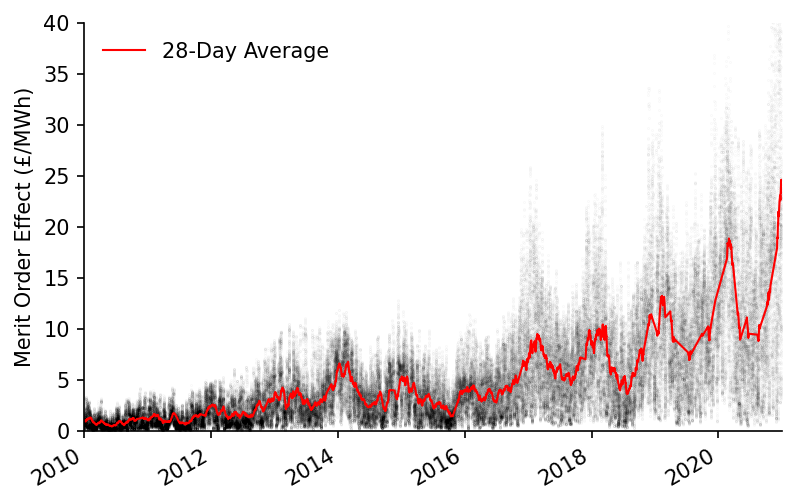

In [424]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_MOE.index, s_MOE, s=0.01, alpha=0.1, color='k', label=None)
s_MOE_rolling.plot(color='r', linewidth=1, ax=ax, label='28-Day Average')

hlp.hide_spines(ax)
ax.set_ylim(0, 40)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (£/MWh)')
ax.legend(frameon=False)

<br>

We can also attribute specific savings from the MOE to the different RES technologies

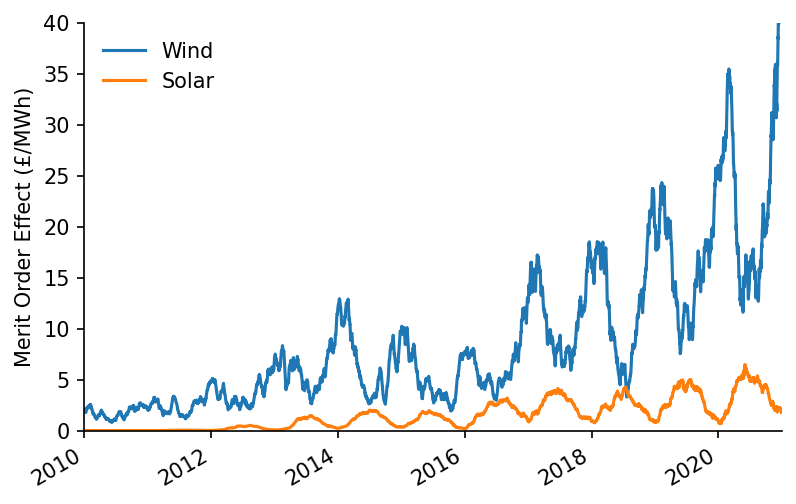

In [402]:
wind_weight = df_EI.loc[s_MOE.index, 'wind']/df_EI.loc[s_MOE.index][['wind', 'solar']].mean(axis=1)
solar_weight = df_EI.loc[s_MOE.index, 'solar']/df_EI.loc[s_MOE.index][['wind', 'solar']].mean(axis=1)

s_wind_MOE = s_MOE*wind_weight
s_solar_MOE = s_MOE*solar_weight

# Plotting
fig, ax = plt.subplots(dpi=150)

s_wind_MOE.rolling(48*28).mean().plot(ax=ax, label='Wind')
s_solar_MOE.rolling(48*28).mean().plot(ax=ax, label='Solar')

ax.set_ylim(0, 40)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (£/MWh)')
ax.legend(frameon=False)
hlp.hide_spines(ax)

<br>

To add some context we'll plot the MOE alongside the actual price, we'll also do this for both years at the extremes of the dataset time range

Text(0, 0.5, 'Price (£/MWh)')

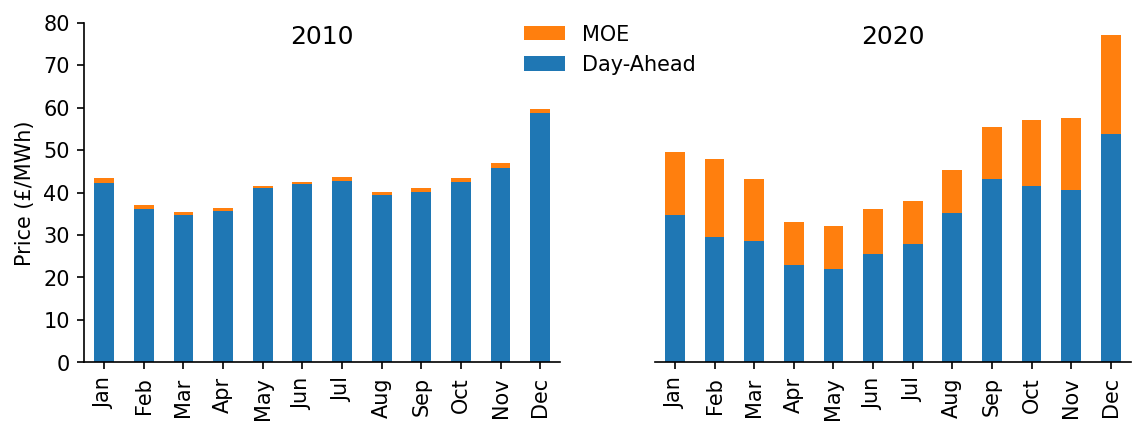

In [264]:
year_1 = '2010'
year_2 = '2020'

month_num_to_name = dict(zip(np.arange(1, 13), pd.date_range('2010-01-01', '2010-12-31', freq='M').strftime('%b')))

s_hourly_dam_10 = s_dam[year_1].groupby(s_dam[year_1].index.month).mean()
s_hourly_MOE_10 = s_MOE[year_1].groupby(s_MOE[year_1].index.month).mean()

s_hourly_dam_20 = s_dam[year_2].groupby(s_dam[year_2].index.month).mean()
s_hourly_MOE_20 = s_MOE[year_2].groupby(s_MOE[year_2].index.month).mean()

for s in [s_hourly_dam_10, s_hourly_MOE_10, s_hourly_dam_20, s_hourly_MOE_20]:
    s.index = s.index.map(month_num_to_name)

# Plotting
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(9, 3))

(s_hourly_dam_10+s_hourly_MOE_10).plot.bar(color='C1', label='MOE', ax=axs[0])
s_hourly_dam_10.plot.bar(label='Price', ax=axs[0])

(s_hourly_dam_20+s_hourly_MOE_20).plot.bar(color='C1', label='MOE', ax=axs[1])
s_hourly_dam_20.plot.bar(label='Day-Ahead', ax=axs[1])

axs[0].set_title(year_1, y=0.9)
axs[1].set_title(year_2, y=0.9)

for ax in axs:
    hlp.hide_spines(ax)
    ax.set_ylim(0, 80)
    ax.set_xlabel('')
    
axs[1].legend(frameon=False, bbox_to_anchor=(0.125, 1.05))
axs[1].set_yticks([])
hlp.hide_spines(axs[1], positions=['left'])

axs[0].set_ylabel('Price (£/MWh)')

<br>

### Wind Capture-Value Ratio

Now we'll turn our focus to calculating the capture-value ratio of wind over time

In [316]:
s_wind = df_EI[['day_ahead_price', 'wind']].dropna()['wind']
s_dam = df_EI[['day_ahead_price', 'wind']].dropna()['day_ahead_price']

In [331]:
#exports
def weighted_mean_s(s, s_weight=None, dt_rng=pd.date_range('2009-12-01', '2021-01-01', freq='W'), end_dt_delta_days=7):
    capture_prices = dict()

    for start_dt in dt_rng:
        end_dt = start_dt + pd.Timedelta(days=end_dt_delta_days)
        
        if s_weight is not None:
            weights = s_weight[start_dt:end_dt]
        else:
            weights=None
            
        capture_prices[start_dt] = np.average(s[start_dt:end_dt], weights=weights)

    s_capture_prices = pd.Series(capture_prices)
    s_capture_prices.index = pd.to_datetime(s_capture_prices.index)

    return s_capture_prices

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


<AxesSubplot:>

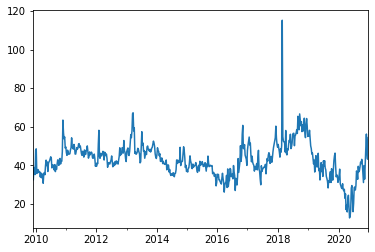

In [332]:
s_wind_capture_prices = weighted_mean_s(s_dam, s_wind)
s_dam_prices = weighted_mean_s(s_dam)

s_wind_capture_prices.plot()

-0.028


<AxesSubplot:ylabel='Count'>

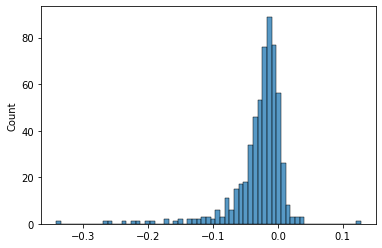

In [435]:
s_wind_capture_value_ratio = (s_wind_capture_prices - s_dam_prices)/s_dam_prices

print(round(s_wind_capture_value_ratio.mean(), 4))
sns.histplot(s_wind_capture_value_ratio)

In [ ]:
# Could be interesting to look at the effect of price suppression on specific wind farms that have CfDs

Text(0, 0.5, 'Wind Capture Price Suppression (%)')

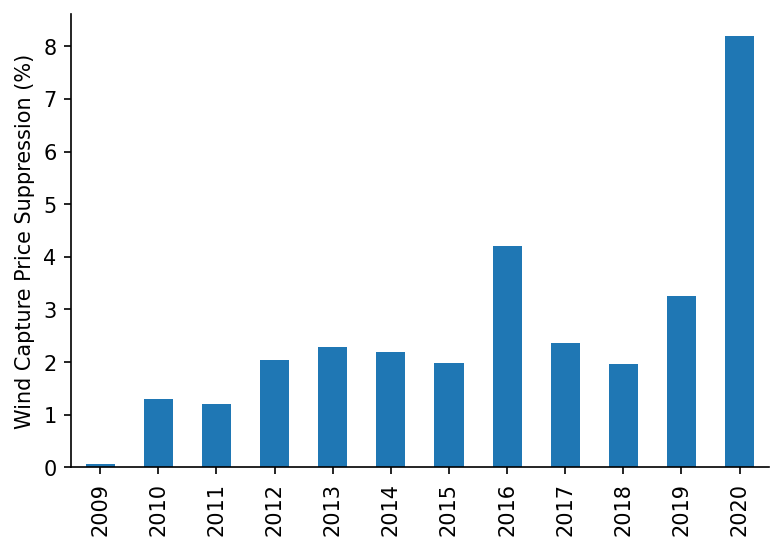

In [436]:
fig, ax = plt.subplots(dpi=150)

(-100*s_wind_capture_value_ratio.groupby(s_wind_capture_value_ratio.index.year).mean()).plot.bar(ax=ax)

hlp.hide_spines(ax)
ax.set_ylabel('Wind Capture Price Suppression (%)')

In [26]:
# repeat for UK carbon intensity
# download DE data for calc'ing MOE of price and carbon intensity 
# should use carbon intensity of the fleet which doesnt include wind and solar - which lower it!

# re-run the analysis using the % share of VRE
# what is the difference in terms of the cumulative MOE?

# re-run the skopt analysis
# clean up the hyper-parameter tuning surface plot

# work out and write the relevant LaTeX equations for both the MOE calculations and the LOWESS calculations

# create pipeline for GB that includes retrieving the data
# run on a monthly cycle using GitHub actions (eventually move to the Pi)

# 

> This effect further intensifies as more VRE is added to the market, which gives rise to the term that VRE ‘cannibalises’ its own revenues. This is also described as the ‘capture-value’ effect, referring to the ratio of the average price received by VRE (weighted by their output) relative to the average market price (i.e. the value they capture). - [source](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3741232)

> The merit-order effect is typically expressed in absolute terms: the change in price for a fixed increase in VRE output (e.g. €/MWh per GW of output). However, we study power systems with very different scales, from an average load of 90 GW in the US PJM market down to less than 1 GW in Latvia and Estonia. Adding a fixed amount of VRE in small systems will have a greater effect. To harmonise for market size we present values in the units of €/MWh per 1 percentage point (ppt.) change in the share of VRE in generation, which we refer to as the ‘relative merit-order effect’ - [source](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3741232)

In [27]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-eda.ipynb.
Converted 03-lowess.ipynb.
Converted 04-surface-estimation.ipynb.
Converted 05-merit-order-effect.ipynb.
